# Policy Gradient Reinforcement Learning:
The objective of a Reinforcement Learning agent is to maximize the "expected" reward when following a policy *π*.<br />
Like any Machine Learning setup, we define a set of parameters *θ* (e.g. the coefficients of a complex polynomial or the weights and biases of units in a neural network) to parametrize this policy — *π_θ* (also written a π for brevity).<br />
If we represent the total reward for a given trajectory *τ* as *r(τ)*, we arrive at the following definition. <br />
#### Reinforcement Learning Objective: Maximize the “expected” reward following a parametrized policy: <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **_J(θ)=Eπ​[r(τ)]_**



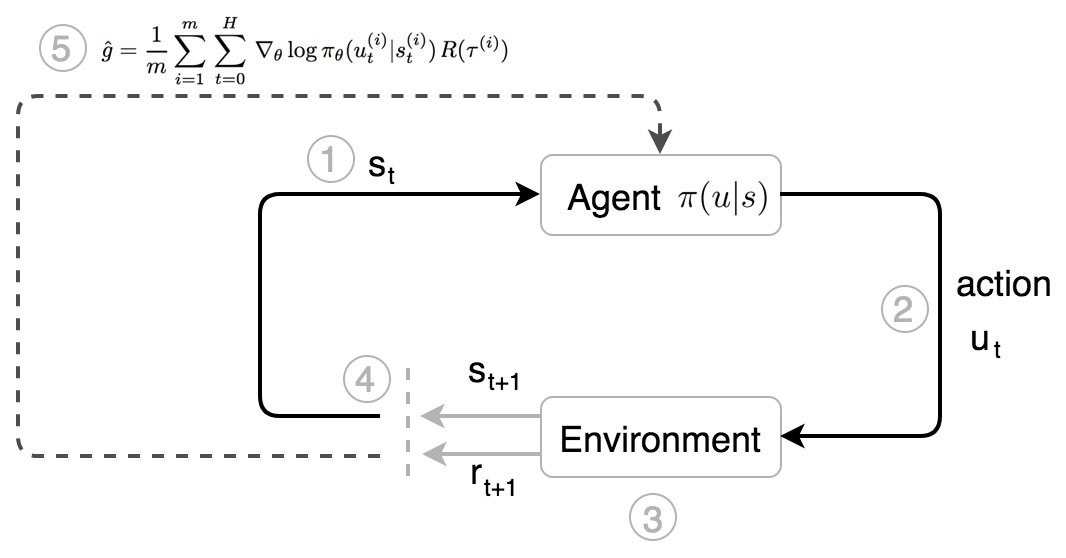
[Image credit](https://cdn-images-1.medium.com/max/1600/1*94EI9DpoXnWa6oLHvh14pw.jpeg)


## Import Libraries:

In [1]:
import sys
from itertools import count

import cv2
import gym_super_mario_bros
from gym.wrappers import Monitor
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY
from nes_py.wrappers import JoypadSpace

import matplotlib.pyplot as plt
import numpy as np
import torch

from policy_agent import Agent
from wrappers import wrapper

## Setting Hyperparameters:

In [2]:
# env settings
WORLD = 1
STAGE = 1
LEVEL_NAME = "SuperMarioBros-{}-{}-v0".format(WORLD, STAGE)
FRAME_DIM = (84, 84, 4)     # (120, 128, 4)  # original image size is 240x256
ACTION_SPACE = SIMPLE_MOVEMENT
RENDER_GAME = False
LOAD_MODEL = False
CHECKPOINT_INTERVAL = 100
MODEL_PATH = "./saved_models/policy_gradient_model_world1-1"  # to create a new model set it to ""

# training hyperparameters
TRAIN_MODEL = True
LEARNING_RATE = 0.000007
NUM_EPOCHS = 1_001
GAMMA = 0.99

LOG_INTERVAL = 1
PLOT_INTERVAL = 50
VIDEO_INTERVAL = 50

## Check Available GPU:

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Available GPU: {torch.cuda.get_device_name(0)}")

Available GPU: Tesla P100-PCIE-12GB


## Environment:
Creates the environment, applies some wrappers and returns it

In [4]:
def create_environment():
    tmp_env = gym_super_mario_bros.make(LEVEL_NAME)
    tmp_env = JoypadSpace(tmp_env, ACTION_SPACE)
    tmp_env = wrapper(tmp_env, FRAME_DIM)

    return tmp_env

## Convert Lazy Frame to Tensor:
pytorch expects the frames as height x width x depth

In [5]:
def lazy_frame_to_tensor(lazy_frame):
    return torch.from_numpy(
        np.expand_dims(np.asarray(lazy_frame).astype(np.float64).transpose((2, 1, 0)), axis=0)).float().to(DEVICE)


## Plot Policy Gradient Reward History:

In [6]:
def plot_rewards(reward_list, reward_mean_history):
    plt.figure(figsize=(12,6))
    plt.plot(reward_list, "#ff36f2", label = "Reward History")
    plt.plot(reward_mean_history, "#5ee000", label = "Mean Reward History")
    plt.ylabel("Rewards", fontsize = 18)
    plt.xlabel("Episodes",fontsize = 18)
    plt.title("Reward Per Episode", fontsize = 18)
    plt.legend()
    plt.show()


## Record Episode:
Record episode based on agent and Actions taken by Mario

In [7]:
def record_one_episode(agent, episode):
    tmp_env = gym_super_mario_bros.make(LEVEL_NAME)
    tmp_env = JoypadSpace(tmp_env, ACTION_SPACE)
    tmp_env = Monitor(tmp_env, './video/video-episode-{0:05d}'.format(episode), force=True)
    tmp_env = wrapper(tmp_env, FRAME_DIM)

    state = lazy_frame_to_tensor(tmp_env.reset())

    total_reward = 0
    while True:
        action, _ = agent.select_action_based_on_state(state)

        next_state, reward, done, info = tmp_env.step(action)
        next_state = lazy_frame_to_tensor(next_state)

        if done:
            break

        total_reward += reward

        state = next_state


## Create Environment and Load Model:
We can load saved model 

In [8]:
env = create_environment()

agent = Agent(env.action_space.n, FRAME_DIM, LEARNING_RATE, GAMMA, DEVICE, MODEL_PATH)
if LOAD_MODEL:
    agent.load_model(model_path=MODEL_PATH)

if not TRAIN_MODEL:
    record_one_episode(agent)
    sys.exit()

## Training Mario:
#### In Policy Gradient Reinforcement Learning:<br />
    Step 1: Observes the state of the environment (_s_).
    Step 2: Takes action (_u_) based on his instinct (a policy _π_) on the state _s_.
    Step 3: A new state is formed.
    Step 4: Takes further actions based on the observed state.
    Step 5: Adjusts actions based on the total rewards _R(τ)_ received.

Episode 1	Last Reward: 591.00	Average reward: 0.00	Loss: -0.85
Episode 2	Last Reward: 728.00	Average reward: 0.00	Loss: 5.79
Episode 3	Last Reward: 243.00	Average reward: 0.00	Loss: -4.38
Episode 4	Last Reward: 950.00	Average reward: 0.00	Loss: -26.62
Episode 5	Last Reward: 636.00	Average reward: 0.00	Loss: -25.73
Episode 6	Last Reward: 243.00	Average reward: 0.00	Loss: -20.51
Episode 7	Last Reward: 237.00	Average reward: 0.00	Loss: -10.92
Episode 8	Last Reward: 750.00	Average reward: 0.00	Loss: -42.47
Episode 9	Last Reward: 1041.00	Average reward: 0.00	Loss: -7.29
Episode 10	Last Reward: 234.00	Average reward: 0.00	Loss: -3.09
Episode 11	Last Reward: 575.00	Average reward: 0.00	Loss: 31.04
Episode 12	Last Reward: 234.00	Average reward: 0.00	Loss: -17.04
Episode 13	Last Reward: 608.00	Average reward: 0.00	Loss: -22.46
Episode 14	Last Reward: 1430.00	Average reward: 0.00	Loss: -33.60
Episode 15	Last Reward: 1421.00	Average reward: 0.00	Loss: -35.27
Episode 16	Last Reward: 1428.00	Averag

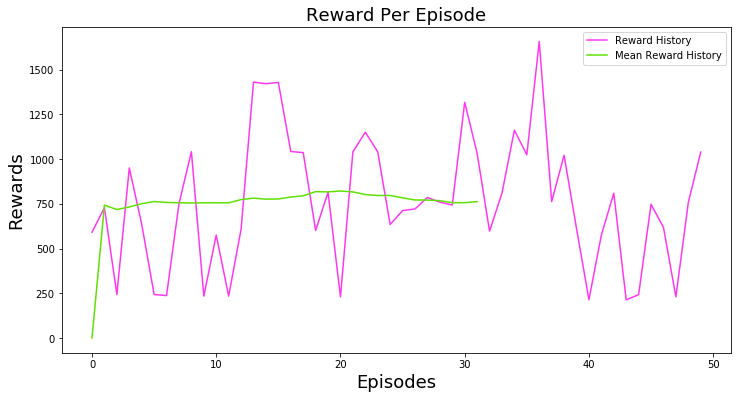

Episode 51	Last Reward: 1056.00	Average reward: 767.61	Loss: -15.36
Episode 52	Last Reward: 727.00	Average reward: 766.83	Loss: -36.84
Episode 53	Last Reward: 1045.00	Average reward: 772.08	Loss: -24.76
Episode 54	Last Reward: 764.00	Average reward: 771.93	Loss: -34.71
Episode 55	Last Reward: 230.00	Average reward: 762.07	Loss: -9.13
Episode 56	Last Reward: 805.00	Average reward: 762.84	Loss: -10.18
Episode 57	Last Reward: 1305.00	Average reward: 772.35	Loss: 7.76
Episode 58	Last Reward: 806.00	Average reward: 772.93	Loss: 17.57
Episode 59	Last Reward: 601.00	Average reward: 770.02	Loss: -8.94
Episode 60	Last Reward: 231.00	Average reward: 761.03	Loss: -8.20
Episode 61	Last Reward: 1035.00	Average reward: 765.52	Loss: 10.66
Episode 62	Last Reward: 231.00	Average reward: 756.90	Loss: -0.97
Episode 63	Last Reward: 230.00	Average reward: 748.54	Loss: 2.66
Episode 64	Last Reward: 231.00	Average reward: 740.45	Loss: -1.03
Episode 65	Last Reward: 231.00	Average reward: 732.62	Loss: -1.10
Epi

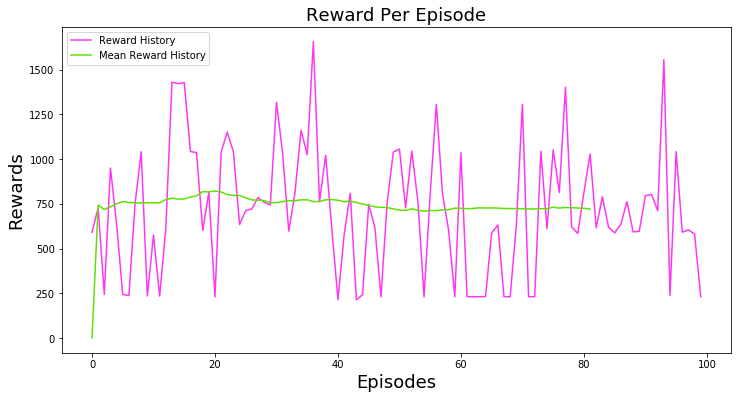

Episode 101	Last Reward: 603.00	Average reward: 718.85	Loss: -6.38
Episode 102	Last Reward: 1050.00	Average reward: 722.10	Loss: 3.44
Episode 103	Last Reward: 715.00	Average reward: 722.03	Loss: -40.10
Episode 104	Last Reward: 1319.00	Average reward: 727.77	Loss: -26.16
Episode 105	Last Reward: 236.00	Average reward: 723.09	Loss: -8.53
Episode 106	Last Reward: 630.00	Average reward: 722.21	Loss: -18.21
Episode 107	Last Reward: 1043.00	Average reward: 725.21	Loss: -5.80
Episode 108	Last Reward: 616.00	Average reward: 724.19	Loss: -19.44
Episode 109	Last Reward: 616.00	Average reward: 723.20	Loss: -19.06
Episode 110	Last Reward: 814.00	Average reward: 724.03	Loss: -28.66
Episode 111	Last Reward: 1323.00	Average reward: 729.42	Loss: -11.55
Episode 112	Last Reward: 1029.00	Average reward: 732.10	Loss: -2.63
Episode 113	Last Reward: 1305.00	Average reward: 737.17	Loss: -19.16
Episode 114	Last Reward: 1033.00	Average reward: 739.76	Loss: 0.39
Episode 115	Last Reward: 1421.00	Average reward: 

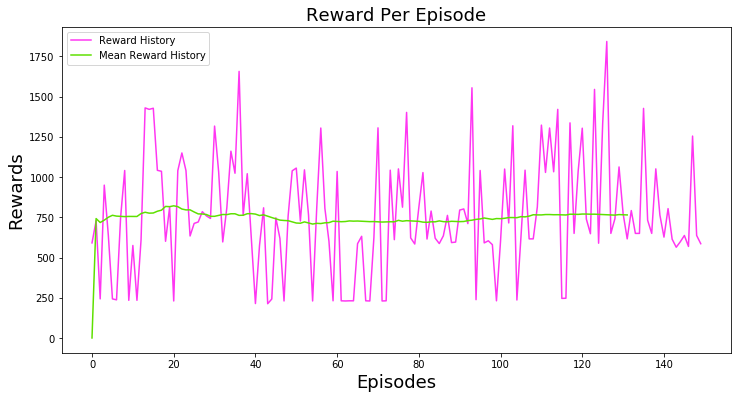

Episode 151	Last Reward: 762.00	Average reward: 764.81	Loss: -1.18
Episode 152	Last Reward: 597.00	Average reward: 763.71	Loss: 0.19
Episode 153	Last Reward: 244.00	Average reward: 760.31	Loss: 5.09
Episode 154	Last Reward: 624.00	Average reward: 759.43	Loss: -0.95
Episode 155	Last Reward: 1038.00	Average reward: 761.23	Loss: 5.98
Episode 156	Last Reward: 806.00	Average reward: 761.51	Loss: 5.25
Episode 157	Last Reward: 1296.00	Average reward: 764.92	Loss: 0.37
Episode 158	Last Reward: 595.00	Average reward: 763.84	Loss: -2.48
Episode 159	Last Reward: 809.00	Average reward: 764.13	Loss: 5.32
Episode 160	Last Reward: 1038.00	Average reward: 765.84	Loss: -5.80
Episode 161	Last Reward: 605.00	Average reward: 764.84	Loss: -0.15
Episode 162	Last Reward: 667.00	Average reward: 764.23	Loss: 11.77
Episode 163	Last Reward: 630.00	Average reward: 763.41	Loss: 4.83
Episode 164	Last Reward: 734.00	Average reward: 763.23	Loss: 5.93
Episode 165	Last Reward: 810.00	Average reward: 763.52	Loss: 9.47
E

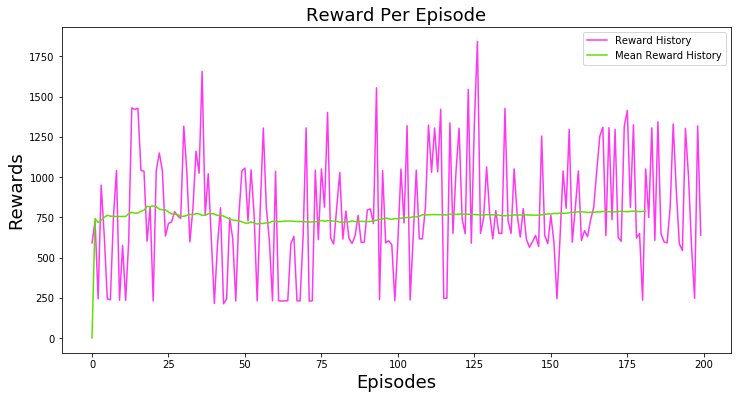

Episode 201	Last Reward: 1423.00	Average reward: 789.73	Loss: -21.61
Episode 202	Last Reward: 267.00	Average reward: 787.14	Loss: -134.37
Episode 203	Last Reward: 1436.00	Average reward: 790.33	Loss: 2.75
Episode 204	Last Reward: 651.00	Average reward: 789.65	Loss: -11.84
Episode 205	Last Reward: 1339.00	Average reward: 792.33	Loss: -25.59
Episode 206	Last Reward: 606.00	Average reward: 791.43	Loss: -5.96
Episode 207	Last Reward: 1044.00	Average reward: 792.65	Loss: -15.17
Episode 208	Last Reward: 234.00	Average reward: 789.96	Loss: -5.39
Episode 209	Last Reward: 616.00	Average reward: 789.13	Loss: -8.74
Episode 210	Last Reward: 246.00	Average reward: 786.54	Loss: -6.83
Episode 211	Last Reward: 1321.00	Average reward: 789.08	Loss: -3.25
Episode 212	Last Reward: 240.00	Average reward: 786.49	Loss: -4.82
Episode 213	Last Reward: 1496.00	Average reward: 789.82	Loss: 9.96
Episode 214	Last Reward: 244.00	Average reward: 787.27	Loss: -5.52
Episode 215	Last Reward: 1044.00	Average reward: 788

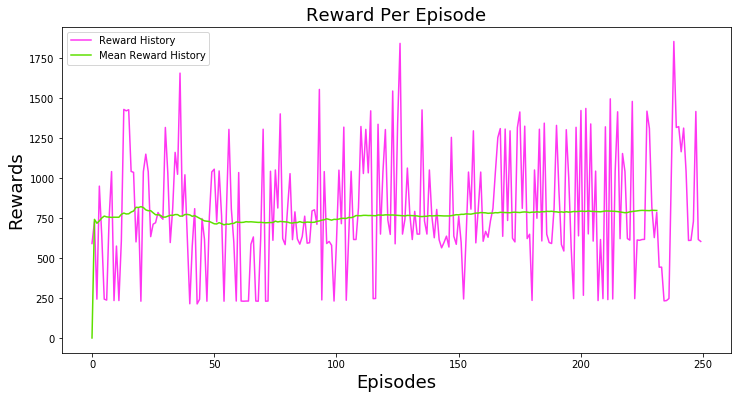

Episode 251	Last Reward: 1669.00	Average reward: 800.98	Loss: -20.29
Saving Video for reward: 1669.0 at episode:251
Episode 252	Last Reward: 607.00	Average reward: 800.21	Loss: -13.89
Episode 253	Last Reward: 619.00	Average reward: 799.49	Loss: -15.23
Episode 254	Last Reward: 1033.00	Average reward: 800.41	Loss: -29.44
Episode 255	Last Reward: 813.00	Average reward: 800.46	Loss: 0.59
Episode 256	Last Reward: 800.00	Average reward: 800.46	Loss: -42.48
Episode 257	Last Reward: 603.00	Average reward: 799.69	Loss: -26.63
Episode 258	Last Reward: 591.00	Average reward: 798.88	Loss: -17.88
Episode 259	Last Reward: 619.00	Average reward: 798.19	Loss: -6.98
Episode 260	Last Reward: 633.00	Average reward: 797.55	Loss: -11.23
Episode 261	Last Reward: 793.00	Average reward: 797.54	Loss: -26.16
Episode 262	Last Reward: 616.00	Average reward: 796.84	Loss: -6.74
Episode 263	Last Reward: 592.00	Average reward: 796.06	Loss: -33.14
Episode 264	Last Reward: 585.00	Average reward: 795.27	Loss: -16.78
Epi

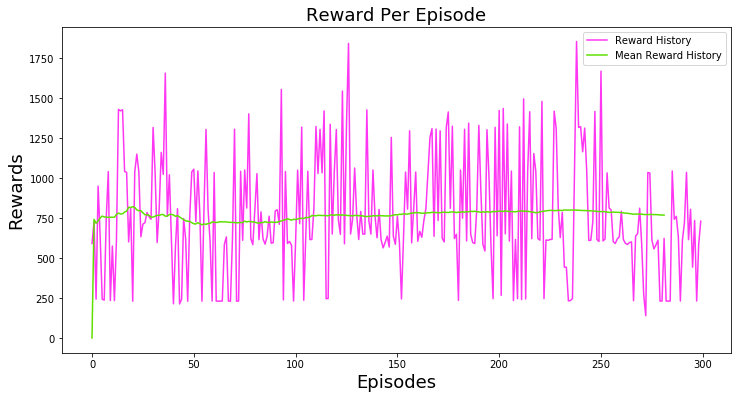

Episode 301	Last Reward: 244.00	Average reward: 766.97	Loss: 1.43
Episode 302	Last Reward: 548.00	Average reward: 766.25	Loss: 14.47
Episode 303	Last Reward: 636.00	Average reward: 765.82	Loss: -8.85
Episode 304	Last Reward: 711.00	Average reward: 765.64	Loss: 19.52
Episode 305	Last Reward: 1042.00	Average reward: 766.54	Loss: 4.58
Episode 306	Last Reward: 335.00	Average reward: 765.13	Loss: 40.92
Episode 307	Last Reward: 591.00	Average reward: 764.57	Loss: -1.56
Episode 308	Last Reward: 267.00	Average reward: 762.95	Loss: 26.76
Episode 309	Last Reward: 579.00	Average reward: 762.36	Loss: 9.42
Episode 310	Last Reward: 540.00	Average reward: 761.64	Loss: 29.38
Episode 311	Last Reward: 527.00	Average reward: 760.88	Loss: 46.42
Episode 312	Last Reward: 231.00	Average reward: 759.19	Loss: -4.66
Episode 313	Last Reward: 585.00	Average reward: 758.63	Loss: 4.38
Episode 314	Last Reward: 572.00	Average reward: 758.04	Loss: -1.48
Episode 315	Last Reward: 592.00	Average reward: 757.51	Loss: 3.40

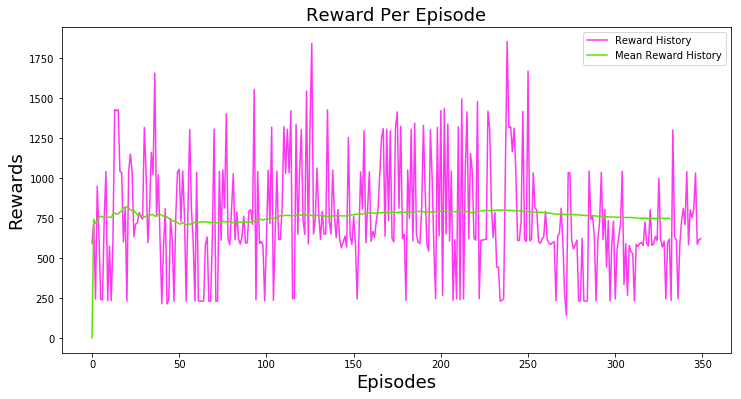

Episode 351	Last Reward: 766.00	Average reward: 748.20	Loss: -11.76
Episode 352	Last Reward: 585.00	Average reward: 747.73	Loss: -12.33
Episode 353	Last Reward: 1022.00	Average reward: 748.51	Loss: -21.49
Episode 354	Last Reward: 267.00	Average reward: 747.15	Loss: 38.42
Episode 355	Last Reward: 598.00	Average reward: 746.73	Loss: -5.95
Episode 356	Last Reward: 234.00	Average reward: 745.29	Loss: 1.15
Episode 357	Last Reward: 1045.00	Average reward: 746.13	Loss: 0.43
Episode 358	Last Reward: 737.00	Average reward: 746.10	Loss: -74.09
Episode 359	Last Reward: 596.00	Average reward: 745.69	Loss: -14.45
Episode 360	Last Reward: 804.00	Average reward: 745.85	Loss: -24.16
Episode 361	Last Reward: 1042.00	Average reward: 746.67	Loss: 4.81
Episode 362	Last Reward: 620.00	Average reward: 746.32	Loss: -2.21
Episode 363	Last Reward: 616.00	Average reward: 745.96	Loss: -2.47
Episode 364	Last Reward: 693.00	Average reward: 745.81	Loss: -58.82
Episode 365	Last Reward: 1036.00	Average reward: 746.61

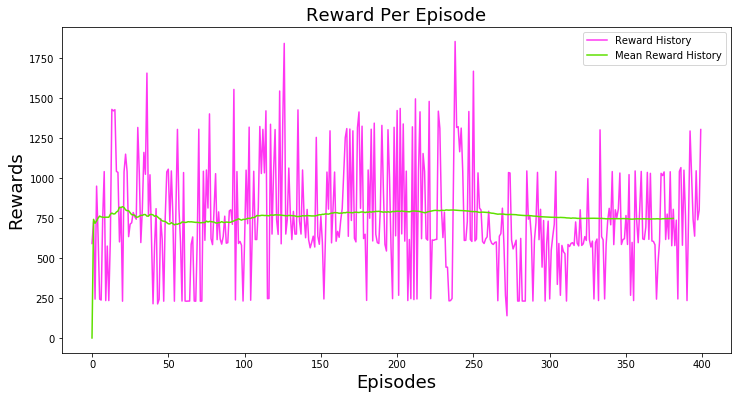

Episode 401	Last Reward: 632.00	Average reward: 748.20	Loss: -6.35
Episode 402	Last Reward: 1316.00	Average reward: 749.61	Loss: -6.68
Episode 403	Last Reward: 788.00	Average reward: 749.71	Loss: -2.69
Episode 404	Last Reward: 615.00	Average reward: 749.38	Loss: -6.12
Episode 405	Last Reward: 1334.00	Average reward: 750.82	Loss: 88.96
Episode 406	Last Reward: 630.00	Average reward: 750.52	Loss: -29.36
Episode 407	Last Reward: 1292.00	Average reward: 751.85	Loss: -13.06
Episode 408	Last Reward: 746.00	Average reward: 751.84	Loss: -15.24
Episode 409	Last Reward: 1557.00	Average reward: 753.81	Loss: 2.80
Saving Video for reward: 1557.0 at episode:409
Episode 410	Last Reward: 234.00	Average reward: 752.54	Loss: -0.91
Episode 411	Last Reward: 1005.00	Average reward: 753.15	Loss: -22.62
Episode 412	Last Reward: 1042.00	Average reward: 753.85	Loss: -9.60
Episode 413	Last Reward: 621.00	Average reward: 753.53	Loss: -2.90
Episode 414	Last Reward: 1038.00	Average reward: 754.22	Loss: -10.46
Epis

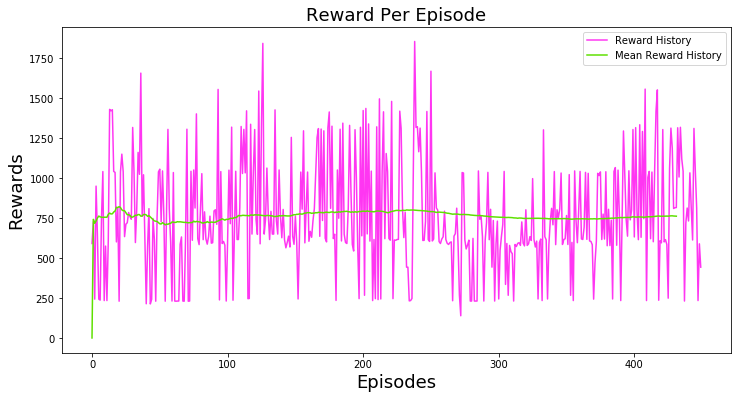

Episode 451	Last Reward: 813.00	Average reward: 762.02	Loss: -52.61
Episode 452	Last Reward: 243.00	Average reward: 760.87	Loss: -1.64
Episode 453	Last Reward: 637.00	Average reward: 760.59	Loss: -14.99
Episode 454	Last Reward: 769.00	Average reward: 760.61	Loss: -28.65
Episode 455	Last Reward: 817.00	Average reward: 760.74	Loss: -26.93
Episode 456	Last Reward: 813.00	Average reward: 760.85	Loss: -35.15
Episode 457	Last Reward: 1305.00	Average reward: 762.04	Loss: -10.71
Episode 458	Last Reward: 1046.00	Average reward: 762.66	Loss: -15.44
Episode 459	Last Reward: 734.00	Average reward: 762.60	Loss: 0.18
Episode 460	Last Reward: 786.00	Average reward: 762.65	Loss: 10.03
Episode 461	Last Reward: 812.00	Average reward: 762.76	Loss: -42.32
Episode 462	Last Reward: 443.00	Average reward: 762.06	Loss: -90.05
Episode 463	Last Reward: 732.00	Average reward: 762.00	Loss: 0.01
Episode 464	Last Reward: 249.00	Average reward: 760.89	Loss: -2.94
Episode 465	Last Reward: 235.00	Average reward: 759.7

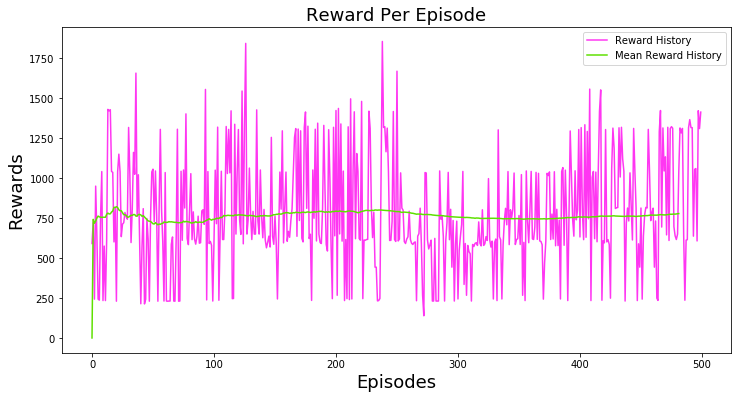

Episode 501	Last Reward: 652.00	Average reward: 778.12	Loss: -1.89
Episode 502	Last Reward: 1317.00	Average reward: 779.19	Loss: -2.23
Episode 503	Last Reward: 249.00	Average reward: 778.14	Loss: -0.25
Episode 504	Last Reward: 598.00	Average reward: 777.78	Loss: -5.93
Episode 505	Last Reward: 739.00	Average reward: 777.70	Loss: -111.00
Episode 506	Last Reward: 622.00	Average reward: 777.39	Loss: -24.26
Episode 507	Last Reward: 581.00	Average reward: 777.01	Loss: -2.71
Episode 508	Last Reward: 609.00	Average reward: 776.68	Loss: -2.40
Episode 509	Last Reward: 599.00	Average reward: 776.33	Loss: -6.17
Episode 510	Last Reward: 1316.00	Average reward: 777.38	Loss: 2.69
Episode 511	Last Reward: 1409.00	Average reward: 778.62	Loss: 17.43
Episode 512	Last Reward: 607.00	Average reward: 778.29	Loss: -8.99
Episode 513	Last Reward: 652.00	Average reward: 778.04	Loss: -7.44
Episode 514	Last Reward: 249.00	Average reward: 777.01	Loss: 0.43
Episode 515	Last Reward: 249.00	Average reward: 775.98	Los

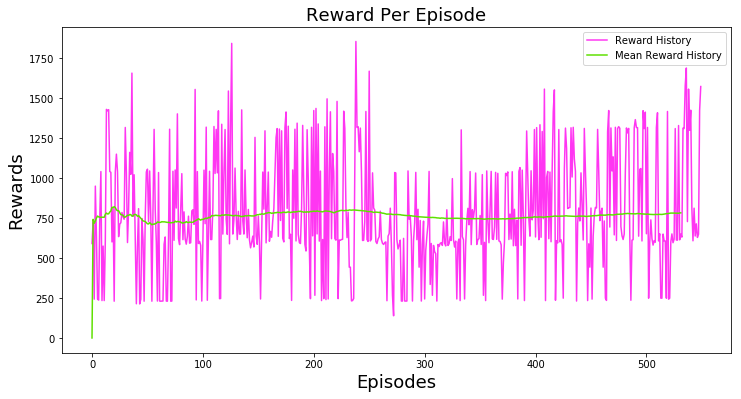

Saving Video for reward: 1573.0 at episode:550
Episode 551	Last Reward: 594.00	Average reward: 782.63	Loss: -15.17
Episode 552	Last Reward: 605.00	Average reward: 782.31	Loss: -4.93
Episode 553	Last Reward: 612.00	Average reward: 782.00	Loss: 6.82
Episode 554	Last Reward: 1056.00	Average reward: 782.50	Loss: -22.70
Episode 555	Last Reward: 1313.00	Average reward: 783.45	Loss: -23.76
Episode 556	Last Reward: 1686.00	Average reward: 785.08	Loss: -17.41
Saving Video for reward: 1686.0 at episode:556
Episode 557	Last Reward: 1319.00	Average reward: 786.03	Loss: 7.10
Episode 558	Last Reward: 793.00	Average reward: 786.05	Loss: -5.50
Episode 559	Last Reward: 618.00	Average reward: 785.75	Loss: -39.39
Episode 560	Last Reward: 1287.00	Average reward: 786.64	Loss: -67.09
Episode 561	Last Reward: 1318.00	Average reward: 787.59	Loss: -5.46
Episode 562	Last Reward: 1847.00	Average reward: 789.47	Loss: -4.75
Saving Video for reward: 1847.0 at episode:562
Episode 563	Last Reward: 621.00	Average rewa

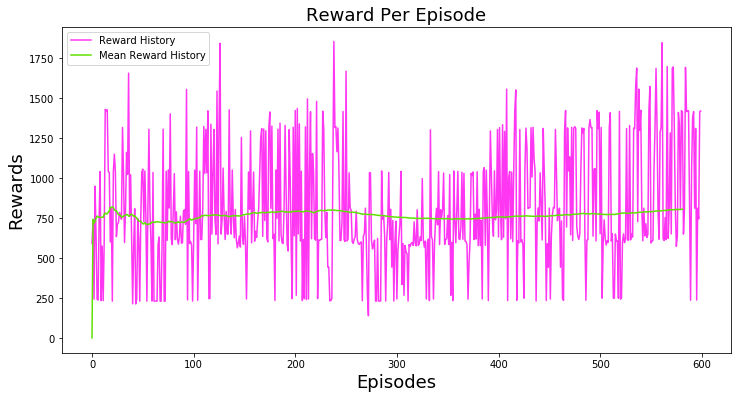

Episode 601	Last Reward: 619.00	Average reward: 805.51	Loss: -9.52
Episode 602	Last Reward: 650.00	Average reward: 805.25	Loss: -3.25
Episode 603	Last Reward: 1414.00	Average reward: 806.26	Loss: 3.14
Episode 604	Last Reward: 1683.00	Average reward: 807.71	Loss: -1.70
Saving Video for reward: 1683.0 at episode:604
Episode 605	Last Reward: 638.00	Average reward: 807.43	Loss: 7.29
Episode 606	Last Reward: 1687.00	Average reward: 808.88	Loss: 0.42
Saving Video for reward: 1687.0 at episode:606
Episode 607	Last Reward: 1331.00	Average reward: 809.74	Loss: 10.28
Episode 608	Last Reward: 1411.00	Average reward: 810.73	Loss: 19.48
Episode 609	Last Reward: 1314.00	Average reward: 811.56	Loss: 7.28
Episode 610	Last Reward: 1426.00	Average reward: 812.57	Loss: -1.17
Episode 611	Last Reward: 236.00	Average reward: 811.62	Loss: -1.69
Episode 612	Last Reward: 1046.00	Average reward: 812.00	Loss: -22.29
Episode 613	Last Reward: 1424.00	Average reward: 813.00	Loss: 3.41
Episode 614	Last Reward: 236.0

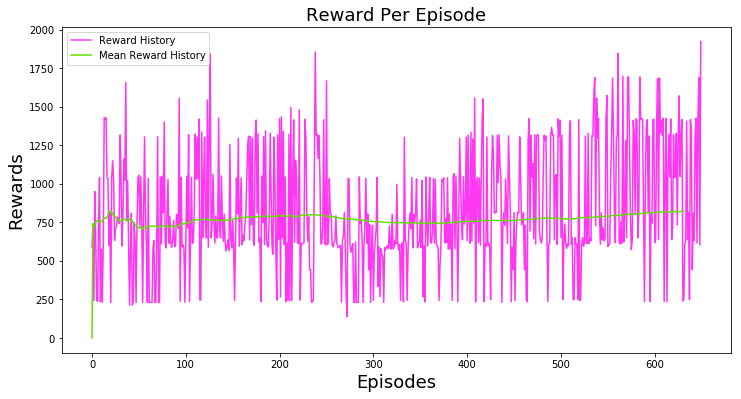

Saving Video for reward: 1924.0 at episode:650
Episode 651	Last Reward: 592.00	Average reward: 823.36	Loss: -4.36
Episode 652	Last Reward: 1321.00	Average reward: 824.13	Loss: 5.51
Episode 653	Last Reward: 1698.00	Average reward: 825.47	Loss: 0.00
Saving Video for reward: 1698.0 at episode:653
Episode 654	Last Reward: 1695.00	Average reward: 826.80	Loss: -4.40
Saving Video for reward: 1695.0 at episode:654
Episode 655	Last Reward: 1423.00	Average reward: 827.71	Loss: -9.73
Episode 656	Last Reward: 1573.00	Average reward: 828.84	Loss: -13.71
Saving Video for reward: 1573.0 at episode:656
Episode 657	Last Reward: 1680.00	Average reward: 830.14	Loss: -24.64
Saving Video for reward: 1680.0 at episode:657
Episode 658	Last Reward: 815.00	Average reward: 830.11	Loss: -9.37
Episode 659	Last Reward: 1689.00	Average reward: 831.42	Loss: 9.73
Saving Video for reward: 1689.0 at episode:659
Episode 660	Last Reward: 1423.00	Average reward: 832.31	Loss: 1.97
Episode 661	Last Reward: 1921.00	Average r

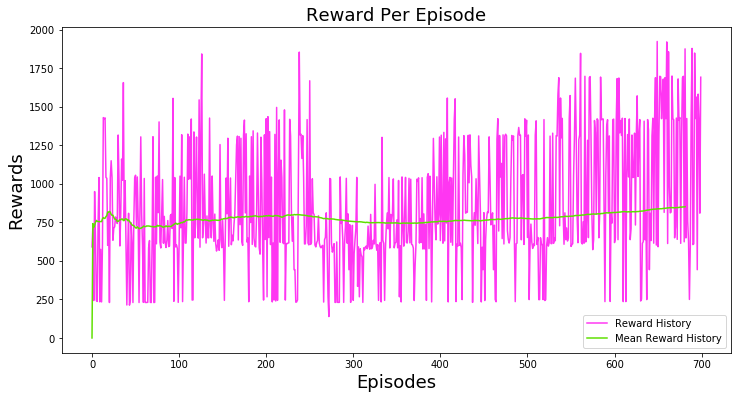

Saving Video for reward: 1692.0 at episode:700
Episode 701	Last Reward: 1426.00	Average reward: 852.63	Loss: -6.36
Episode 702	Last Reward: 1694.00	Average reward: 853.83	Loss: 4.86
Saving Video for reward: 1694.0 at episode:702
Episode 703	Last Reward: 1321.00	Average reward: 854.49	Loss: -6.64
Episode 704	Last Reward: 1773.00	Average reward: 855.80	Loss: 67.42
Saving Video for reward: 1773.0 at episode:704
Episode 705	Last Reward: 1925.00	Average reward: 857.31	Loss: -20.93
Saving Video for reward: 1925.0 at episode:705
Episode 706	Last Reward: 1693.00	Average reward: 858.50	Loss: 4.10
Saving Video for reward: 1693.0 at episode:706
Episode 707	Last Reward: 1916.00	Average reward: 859.99	Loss: 11.03
Saving Video for reward: 1916.0 at episode:707
Episode 708	Last Reward: 1424.00	Average reward: 860.79	Loss: -3.60
Episode 709	Last Reward: 1691.00	Average reward: 861.96	Loss: -7.54
Saving Video for reward: 1691.0 at episode:709
Episode 710	Last Reward: 1574.00	Average reward: 862.96	Loss

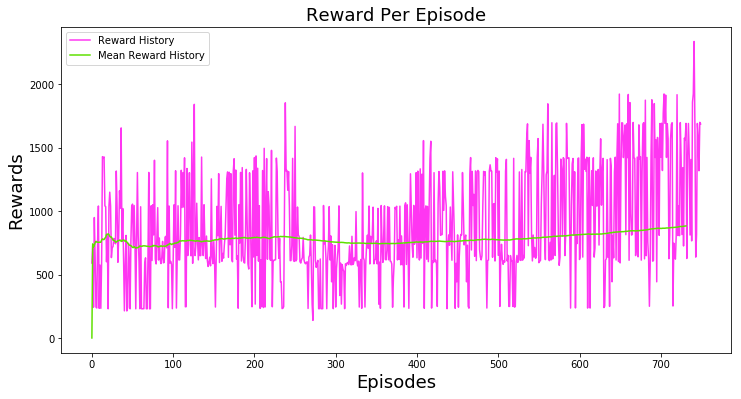

Saving Video for reward: 1688.0 at episode:750
Episode 751	Last Reward: 1702.00	Average reward: 885.05	Loss: -15.50
Saving Video for reward: 1702.0 at episode:751
Episode 752	Last Reward: 798.00	Average reward: 884.93	Loss: 2.63
Episode 753	Last Reward: 1923.00	Average reward: 886.31	Loss: 0.69
Saving Video for reward: 1923.0 at episode:753
Episode 754	Last Reward: 1416.00	Average reward: 887.01	Loss: -6.36
Episode 755	Last Reward: 1319.00	Average reward: 887.59	Loss: -6.45
Episode 756	Last Reward: 1706.00	Average reward: 888.67	Loss: -15.69
Saving Video for reward: 1706.0 at episode:756
Episode 757	Last Reward: 1690.00	Average reward: 889.73	Loss: -4.95
Saving Video for reward: 1690.0 at episode:757
Episode 758	Last Reward: 1432.00	Average reward: 890.44	Loss: -0.53
Episode 759	Last Reward: 819.00	Average reward: 890.35	Loss: -22.06
Episode 760	Last Reward: 1692.00	Average reward: 891.40	Loss: -17.96
Saving Video for reward: 1692.0 at episode:760
Episode 761	Last Reward: 1432.00	Avera

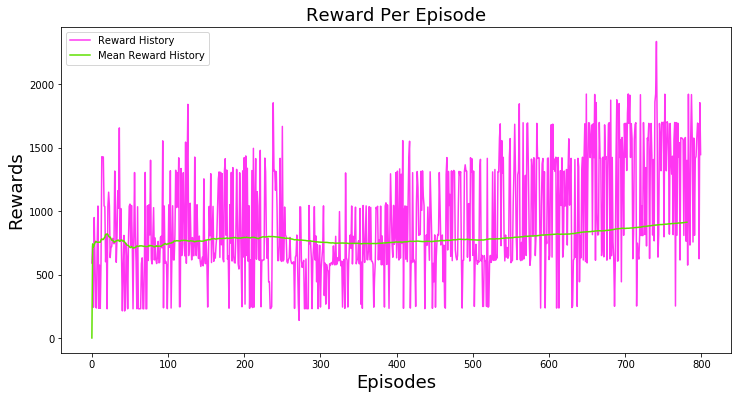

Episode 801	Last Reward: 1581.00	Average reward: 913.80	Loss: -2.48
Saving Video for reward: 1581.0 at episode:801
Episode 802	Last Reward: 1684.00	Average reward: 914.76	Loss: 44.47
Saving Video for reward: 1684.0 at episode:802
Episode 803	Last Reward: 234.00	Average reward: 913.91	Loss: -0.43
Episode 804	Last Reward: 300.00	Average reward: 913.15	Loss: 40.71
Episode 805	Last Reward: 1695.00	Average reward: 914.12	Loss: -2.40
Saving Video for reward: 1695.0 at episode:805
Episode 806	Last Reward: 1051.00	Average reward: 914.29	Loss: -4.82
Episode 807	Last Reward: 1425.00	Average reward: 914.92	Loss: 12.61
Episode 808	Last Reward: 1704.00	Average reward: 915.90	Loss: 2.45
Saving Video for reward: 1704.0 at episode:808
Episode 809	Last Reward: 1338.00	Average reward: 916.42	Loss: 27.46
Episode 810	Last Reward: 1307.00	Average reward: 916.90	Loss: 3.43
Episode 811	Last Reward: 1653.00	Average reward: 917.81	Loss: 24.68
Saving Video for reward: 1653.0 at episode:811
Episode 812	Last Rewa

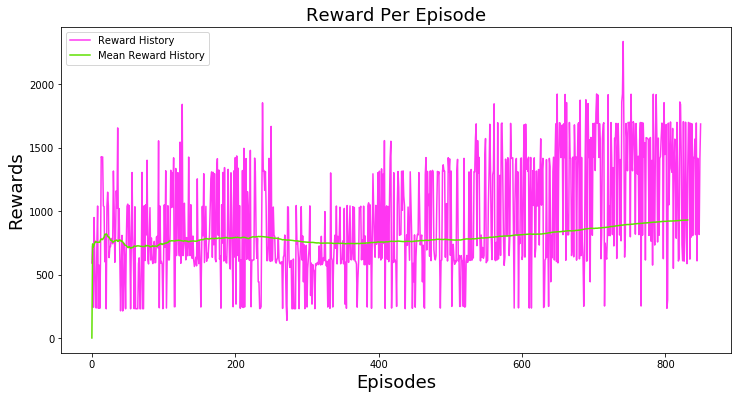

Saving Video for reward: 1688.0 at episode:850
Episode 851	Last Reward: 1049.00	Average reward: 931.11	Loss: -0.43
Episode 852	Last Reward: 625.00	Average reward: 930.75	Loss: -5.40
Episode 853	Last Reward: 1049.00	Average reward: 930.89	Loss: -8.01
Episode 854	Last Reward: 1693.00	Average reward: 931.78	Loss: -11.00
Saving Video for reward: 1693.0 at episode:854
Episode 855	Last Reward: 1693.00	Average reward: 932.67	Loss: -8.79
Saving Video for reward: 1693.0 at episode:855
Episode 856	Last Reward: 1343.00	Average reward: 933.15	Loss: -10.97
Episode 857	Last Reward: 1434.00	Average reward: 933.73	Loss: -8.69
Episode 858	Last Reward: 1331.00	Average reward: 934.19	Loss: -10.98
Episode 859	Last Reward: 1048.00	Average reward: 934.33	Loss: -11.17
Episode 860	Last Reward: 1433.00	Average reward: 934.91	Loss: -13.78
Episode 861	Last Reward: 1677.00	Average reward: 935.77	Loss: 15.38
Saving Video for reward: 1677.0 at episode:861
Episode 862	Last Reward: 1694.00	Average reward: 936.65	Loss

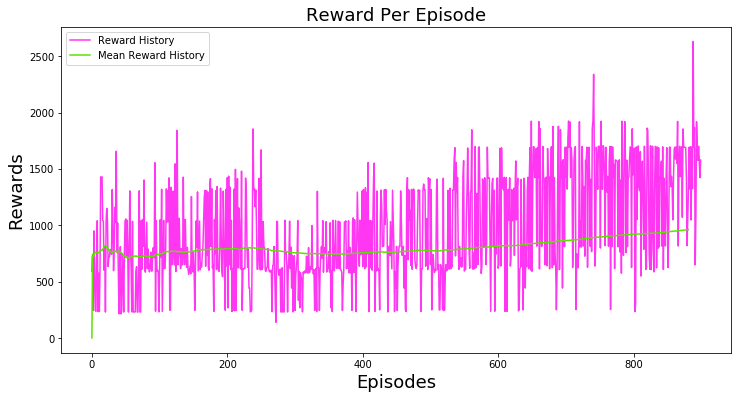

Saving Video for reward: 1579.0 at episode:900
Episode 901	Last Reward: 1924.00	Average reward: 962.63	Loss: 2.83
Saving Video for reward: 1924.0 at episode:901
Episode 902	Last Reward: 1910.00	Average reward: 963.68	Loss: 3.72
Saving Video for reward: 1910.0 at episode:902
Episode 903	Last Reward: 598.00	Average reward: 963.27	Loss: -12.39
Episode 904	Last Reward: 1686.00	Average reward: 964.07	Loss: -11.41
Saving Video for reward: 1686.0 at episode:904
Episode 905	Last Reward: 249.00	Average reward: 963.28	Loss: 3.38
Episode 906	Last Reward: 1853.00	Average reward: 964.26	Loss: -19.09
Saving Video for reward: 1853.0 at episode:906
Episode 907	Last Reward: 2349.00	Average reward: 965.79	Loss: -32.51
Saving Video for reward: 2349.0 at episode:907
Episode 908	Last Reward: 815.00	Average reward: 965.63	Loss: -39.75
Episode 909	Last Reward: 1853.00	Average reward: 966.60	Loss: -3.60
Saving Video for reward: 1853.0 at episode:909
Episode 910	Last Reward: 779.00	Average reward: 966.40	Loss:

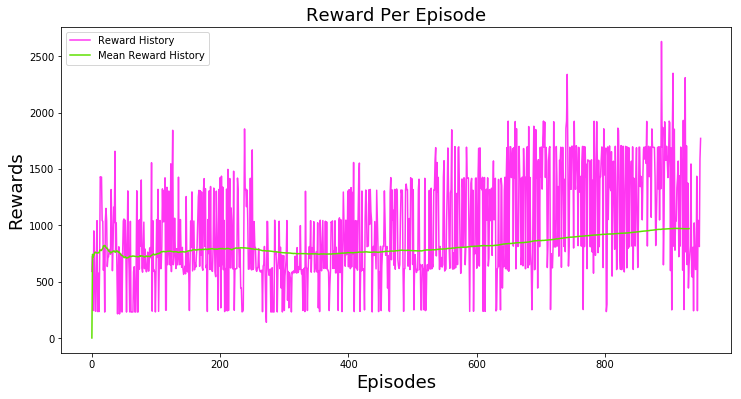

Saving Video for reward: 1771.0 at episode:950
Episode 951	Last Reward: 250.00	Average reward: 969.67	Loss: 6.06
Episode 952	Last Reward: 1562.00	Average reward: 970.30	Loss: 10.24
Saving Video for reward: 1562.0 at episode:952
Episode 953	Last Reward: 249.00	Average reward: 969.54	Loss: 2.53
Episode 954	Last Reward: 1581.00	Average reward: 970.18	Loss: -10.46
Saving Video for reward: 1581.0 at episode:954
Episode 955	Last Reward: 812.00	Average reward: 970.01	Loss: 1.21
Episode 956	Last Reward: 650.00	Average reward: 969.68	Loss: -5.65
Episode 957	Last Reward: 787.00	Average reward: 969.49	Loss: -12.26
Episode 958	Last Reward: 1576.00	Average reward: 970.12	Loss: -1.46
Saving Video for reward: 1576.0 at episode:958
Episode 959	Last Reward: 1579.00	Average reward: 970.76	Loss: 1.16
Saving Video for reward: 1579.0 at episode:959
Episode 960	Last Reward: 601.00	Average reward: 970.37	Loss: -2.84
Episode 961	Last Reward: 811.00	Average reward: 970.20	Loss: -1.19
Episode 962	Last Reward: 6

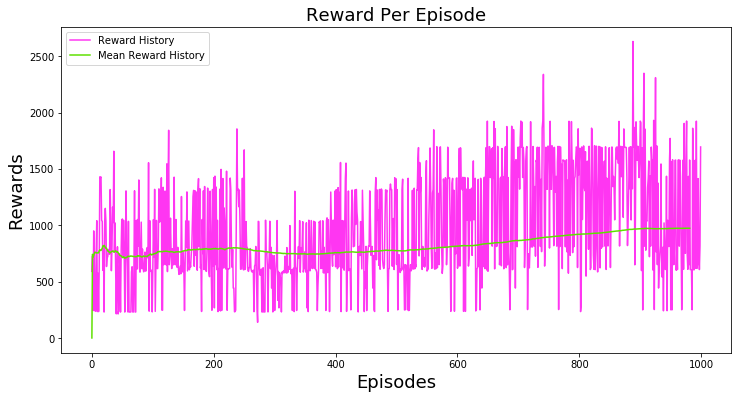

Saving Video for reward: 1695.0 at episode:1000


In [9]:
reward_history = []
reward_mean_history = [0]

step_log_prob_history = []
step_reward_history = []

# save one example warped image for preview
state = env.reset()
cv2.imwrite("exampleImage.jpg", np.asarray(state))

for episode in range(1, NUM_EPOCHS):
    torch.cuda.memory_summary(device=None, abbreviated=False)
    state, last_reward = lazy_frame_to_tensor(env.reset()), 0
    if episode % 100 == 0:
        torch.cuda.empty_cache()
    for step in count():
        # perform an action
        action, log_prob = agent.select_action_based_on_state(state)
        step_log_prob_history.append(log_prob)
        # delete the last state to prevent memory overflow
        del state
        state, reward, done, info = env.step(action)

        if done and reward < 0:
            # if we died the reward will be less than zero
            step_reward_history.append(reward)

            last_reward += reward
            reward_history.append(last_reward)
            if episode >= 20:
                reward_mean_history.append(np.mean(reward_history))
            break

        if done and reward > 0:
            # if we solved the current level give mario the highest possible reward of 15
            step_reward_history.append(15)

            last_reward += 15
            reward_history.append(last_reward)
            if episode >= 20:
                reward_mean_history.append(np.mean(reward_history))
            print("Finished the level")
            break

        state = lazy_frame_to_tensor(state)

        if RENDER_GAME:
            env.render()

        step_reward_history.append(reward)
        last_reward += reward

    loss = agent.update(step_log_prob_history, step_reward_history)

    if episode % LOG_INTERVAL == 0:
        print("Episode {}\tLast Reward: {:.2f}\tAverage reward: {:.2f}\tLoss: {:.2f}".format(episode, last_reward,
                                                                                             reward_mean_history[-1],
                                                                                             loss))

    if episode % PLOT_INTERVAL == 0:
        plot_rewards(reward_history, reward_mean_history)
    # if episode % VIDEO_INTERVAL == 0:
    if last_reward >= 1500:
        print(f"Saving Video for reward: {last_reward} at episode:{episode}")
#         record_one_episode(agent, episode)
    if episode % CHECKPOINT_INTERVAL == 0:
        agent.save_model(model_path=MODEL_PATH)
    del loss
    del step_reward_history[:]
    del step_reward_history[:]
    step_reward_history = []
    step_log_prob_history = []